In [2]:
import pandas as pd
import numpy as np
import os

# --- CONFIGURATION ---
RAW_DATA_PATH = "../data/raw/online_retail_II.xlsx"
PROCESSED_DATA_PATH = "../data/processed/online_retail_cleaned.csv"

# 1. LOAD DATA 
print("Loading raw data...")
df_2009 = pd.read_excel(RAW_DATA_PATH, sheet_name='Year 2009-2010')
df_2010 = pd.read_excel(RAW_DATA_PATH, sheet_name='Year 2010-2011')

# Combine both sheets
df = pd.concat([df_2009, df_2010], ignore_index=True)
print(f"Initial Row Count: {df.shape[0]:,}")

# 2. CLEANING: Remove Null CustomerIDs
# We cannot segment customers if we don't know who they are.
df = df.dropna(subset=['Customer ID'])
print(f"Rows after dropping null Customer ID: {df.shape[0]:,}")

# 3. CLEANING: Remove Cancellations & Bad Data
# Remove invoices starting with 'C' (Cancellations)
df = df[~df['Invoice'].astype(str).str.startswith('C')]

# Remove records with negative or zero Quantity/Price
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# 4. CLEANING: Filter Operational 'Junk' Codes
junk_codes = ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK', 'BANK CHARGES']
df = df[~df['StockCode'].isin(junk_codes)]

# 5. FEATURE ENGINEERING: Total Sales
df['TotalSales'] = df['Quantity'] * df['Price']

# 6. SAVE TO PROCESSED
#save as CSV to load faster next time.
print("Saving cleaned data...")
df.to_csv(PROCESSED_DATA_PATH, index=False)
print(f"SUCCESS! Final Cleaned Data Saved to: {PROCESSED_DATA_PATH}")
print(f"Final Row Count: {df.shape[0]:,}")

Loading raw data...
Initial Row Count: 1,067,371
Rows after dropping null Customer ID: 824,364
Saving cleaned data...
SUCCESS! Final Cleaned Data Saved to: ../data/processed/online_retail_cleaned.csv
Final Row Count: 802,932


In [3]:
#EXECUTING THE TRANSFORMATION


# CONFIGURATION 
# setting the 'Snapshot Date' to 1 day after the last transaction in the dataset
# This simulates doing the analysis on the day the data was pulled.
snapshot_date = df['InvoiceDate'].max() + pd.DateOffset(days=1)

print(f"Snapshot Date: {snapshot_date}")

# AGGREGATION 
# Group by CustomerID and calculate RFM metrics
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                     # Frequency
    'TotalSales': 'sum'                                       # Monetary
})

# Rename columns for clarity
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'TotalSales': 'Monetary'
}, inplace=True)

# Sanity Check
print(f"Customer Count: {rfm.shape[0]}")
display(rfm.head())

Snapshot Date: 2011-12-10 12:50:00
Customer Count: 5862


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,12,77556.46
12347.0,2,8,5633.32
12348.0,75,5,1658.40
12349.0,19,3,3678.69
12350.0,310,1,294.40


In [9]:
# ============================================
# ADVANCED FEATURE ENGINEERING
# ============================================
print("Starting Advanced Feature Engineering...")

# Step 1: Add time-based columns to main df
print("1/4: Calculating temporal patterns...")
df['hour'] = df['InvoiceDate'].dt.hour
df['day_of_week'] = df['InvoiceDate'].dt.dayofweek
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

# Step 2: Calculate features PER CUSTOMER
print("2/4: Engineering behavioral features...")

# Get snapshot date
snapshot_date = df['InvoiceDate'].max() + pd.DateOffset(days=1)

# Create feature dictionary for each customer
customer_features_list = []

for customer_id in df['Customer ID'].unique():
    customer_data = df[df['Customer ID'] == customer_id].copy()
    
    # Sort by date
    customer_data = customer_data.sort_values('InvoiceDate')
    
    # Calculate all features
    features = {
        'Customer ID': customer_id,
        
        # RFM
        'Recency': (snapshot_date - customer_data['InvoiceDate'].max()).days,
        'Frequency': customer_data['Invoice'].nunique(),
        'Monetary': customer_data['TotalSales'].sum(),
        
        # Time-based
        'customer_age_days': (customer_data['InvoiceDate'].max() - customer_data['InvoiceDate'].min()).days,
        'days_between_purchases': (customer_data['InvoiceDate'].max() - customer_data['InvoiceDate'].min()).days / customer_data['Invoice'].nunique() if customer_data['Invoice'].nunique() > 1 else 0,
        
        # Recent activity
        'orders_last_30d': customer_data[customer_data['InvoiceDate'] > (snapshot_date - pd.Timedelta(days=30))]['Invoice'].nunique(),
        'orders_last_90d': customer_data[customer_data['InvoiceDate'] > (snapshot_date - pd.Timedelta(days=90))]['Invoice'].nunique(),
        
        # Order values
        'avg_order_value': customer_data.groupby('Invoice')['TotalSales'].sum().mean(),
        'max_order_value': customer_data.groupby('Invoice')['TotalSales'].sum().max(),
        'min_order_value': customer_data.groupby('Invoice')['TotalSales'].sum().min(),
        'std_order_value': customer_data.groupby('Invoice')['TotalSales'].sum().std(),
        
        # Product diversity
        'product_diversity': customer_data['StockCode'].nunique(),
        'repeat_purchase_rate': 1 - (customer_data['StockCode'].nunique() / len(customer_data)),
        
        # Basket metrics
        'avg_basket_size': customer_data.groupby('Invoice')['Quantity'].sum().mean(),
        'total_items_bought': customer_data['Quantity'].sum(),
        
        # Shopping patterns
        'is_weekend': customer_data['is_weekend'].mean(),
        'hour': customer_data['hour'].mode()[0] if len(customer_data['hour'].mode()) > 0 else 12,
        
        # Spending trend
        'spending_increasing': 1 if len(customer_data) >= 4 and customer_data.iloc[len(customer_data)//2:]['TotalSales'].mean() > customer_data.iloc[:len(customer_data)//2]['TotalSales'].mean() else 0
    }
    
    customer_features_list.append(features)

# Convert to DataFrame
print("3/4: Creating DataFrame...")
rfm_enhanced = pd.DataFrame(customer_features_list)

# Fill NaN values
print("4/4: Cleaning features...")
rfm_enhanced = rfm_enhanced.fillna(0)

# Verify
print(f"\nFeature Engineering Complete!")
print(f"Total Features: {len(rfm_enhanced.columns) - 1}")  # -1 for Customer ID
print(f"Customer Count: {len(rfm_enhanced)}")
print(f"\nColumn Names:")
print(rfm_enhanced.columns.tolist())
print("\nPreview:")
display(rfm_enhanced.head())

Starting Advanced Feature Engineering...
1/4: Calculating temporal patterns...
2/4: Engineering behavioral features...
3/4: Creating DataFrame...
4/4: Cleaning features...

Feature Engineering Complete!
Total Features: 18
Customer Count: 5862

Column Names:
['Customer ID', 'Recency', 'Frequency', 'Monetary', 'customer_age_days', 'days_between_purchases', 'orders_last_30d', 'orders_last_90d', 'avg_order_value', 'max_order_value', 'min_order_value', 'std_order_value', 'product_diversity', 'repeat_purchase_rate', 'avg_basket_size', 'total_items_bought', 'is_weekend', 'hour', 'spending_increasing']

Preview:


,Customer ID,Recency,Frequency,Monetary,customer_age_days,days_between_purchases,orders_last_30d,orders_last_90d,avg_order_value,max_order_value,min_order_value,std_order_value,product_diversity,repeat_purchase_rate,avg_basket_size,total_items_bought,is_weekend,hour,spending_increasing
0,13085.0,158,8,2433.28,581,72.625000,0,0,304.160000,505.30,137.98,153.577298,50,0.404762,118.000000,944,0.000000,11,0
1,13078.0,3,57,29532.45,735,12.894737,4,11,518.113158,1028.78,100.80,207.007865,153,0.808989,213.736842,12183,0.108614,9,0
2,15362.0,449,2,613.08,290,145.000000,0,0,306.540000,310.75,302.33,5.953839,38,0.050000,184.000000,368,0.000000,9,1
3,18102.0,1,145,608821.65,738,5.089655,4,33,4198.770000,31770.98,6.80,5458.547522,382,0.638941,1298.896552,188340,0.016068,11,1
4,12682.0,4,51,21693.91,735,14.411765,4,11,425.370784,1298.10,81.60,232.839802,326,0.670374,213.490196,10888,0.040445,13,1


Preparing features for clustering...
Using 6 enhanced features for clustering

Data Normalized!
Features used: ['Recency', 'Frequency', 'Monetary', 'customer_age_days', 'product_diversity', 'avg_order_value']
Shape: (5862, 6)

Summary Stats (should be ~0 mean, ~1 std):
       Recency  Frequency  Monetary  customer_age_days  product_diversity  \
count  5862.00    5862.00   5862.00            5862.00            5862.00   
mean     -0.00       0.00      0.00              -0.00              -0.00   
std       1.00       1.00      1.00               1.00               1.00   
min      -2.41      -1.06     -3.93              -1.49              -2.53   
25%      -0.74      -1.06     -0.71              -1.49              -0.63   
50%       0.08      -0.20     -0.03               0.52               0.05   
75%       0.95       0.66      0.66               0.83               0.73   
max       1.38       5.43      4.69               0.97               3.36   

       avg_order_value  
count      

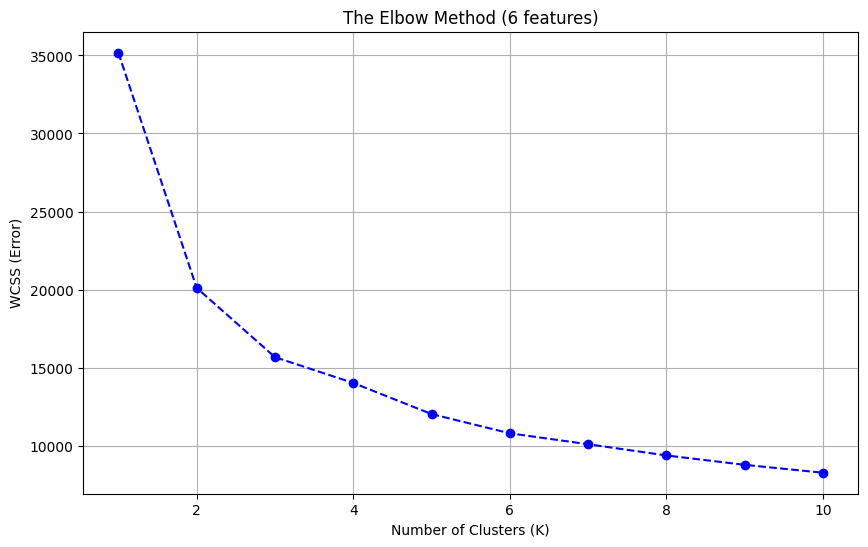

Recommended: K=4 clusters


In [11]:
#PREPROCESSING AND ELBOW METHOD (FIXED)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

print("Preparing features for clustering...")

# Check if we have enhanced features
try:
    clustering_features = rfm_enhanced[[
        'Recency', 
        'Frequency', 
        'Monetary',
        'customer_age_days',
        'product_diversity',
        'avg_order_value'
    ]].copy()
    print("Using 6 enhanced features for clustering")
except KeyError as e:
    print(f"  Column error: {e}")
    print(f"Available columns: {rfm_enhanced.columns.tolist()}")
    # Fallback to basic RFM
    clustering_features = rfm_enhanced[['Recency', 'Frequency', 'Monetary']].copy()
    print("  Falling back to basic RFM (3 features)")

# Log transform to handle skewness
rfm_log = np.log(clustering_features + 1)

# Standardize
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm_log)

# Convert back to DataFrame
rfm_scaled = pd.DataFrame(
    rfm_normalized, 
    index=clustering_features.index, 
    columns=clustering_features.columns
)

print("\nData Normalized!")
print(f"Features used: {list(rfm_scaled.columns)}")
print(f"Shape: {rfm_scaled.shape}")
print("\nSummary Stats (should be ~0 mean, ~1 std):")
print(rfm_scaled.describe().round(2))

# 2. THE ELBOW METHOD 
print("\nRunning Elbow Method...")
wcss = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='b')
plt.title(f'The Elbow Method ({len(clustering_features.columns)} features)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Error)')
plt.grid(True)
plt.show()

print("Recommended: K=4 clusters")

🚀 Training Enhanced Churn Model...
Cutoff Date: 2011-09-10 12:50:00
Created 5266 customer labels
   Churn Rate: 56.5%

Merged Data Shape: (5266, 20)

Features: 17
 Samples: 5266
Class Balance:
Retained (0): 2289 (43.5%)
Churned (1): 2977 (56.5%)

  Split Complete:
   Training: 4212 samples
   Testing: 1054 samples

🔧 Training XGBoost Classifier...

 MODEL PERFORMANCE REPORT
              precision    recall  f1-score   support

    Retained       1.00      0.99      1.00       458
     Churned       0.99      1.00      1.00       596

    accuracy                           1.00      1054
   macro avg       1.00      1.00      1.00      1054
weighted avg       1.00      1.00      1.00      1054


 ROC-AUC Score: 1.000

 Confusion Matrix:
   True Negatives (Correct Retained): 455
   False Positives (False Alarm): 3
   False Negatives (Missed Churners): 0
   True Positives (Caught Churners): 596

Generating Feature Importance Plot...


<Figure size 1200x800 with 0 Axes>

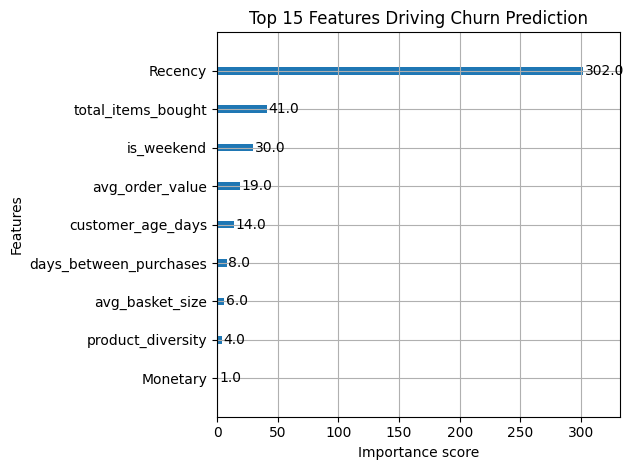


Model Training Complete!
Using 17 features (vs original 3 RFM)


In [14]:
# ============================================
# STEP 3: TRAINING THE PREDICTION MODEL (Enhanced)
# ============================================
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

print("🚀 Training Enhanced Churn Model...")
print("="*60)

# --- 1. PREPARE DATA ---
# First, we need to create the churn labels (targets)
# This uses the "time machine" approach from your original notebook

# Set cutoff date (90 days before end of data)
cutoff_date = df['InvoiceDate'].max() - pd.DateOffset(days=90)
print(f"Cutoff Date: {cutoff_date}")

# Split data
train_df = df[df['InvoiceDate'] < cutoff_date]
test_df = df[df['InvoiceDate'] >= cutoff_date]

# Calculate RFM on training period
snapshot_for_training = cutoff_date

targets_list = []
for customer_id in train_df['Customer ID'].unique():
    customer_train = train_df[train_df['Customer ID'] == customer_id]
    
    # Did they buy AFTER cutoff?
    bought_after = customer_id in test_df['Customer ID'].values
    
    targets_list.append({
        'Customer ID': customer_id,
        'Churn': 0 if bought_after else 1  # 0 = Retained, 1 = Churned
    })

targets = pd.DataFrame(targets_list)
print(f"Created {len(targets)} customer labels")
print(f"   Churn Rate: {targets['Churn'].mean():.1%}")

# --- 2. MERGE FEATURES WITH LABELS ---
# Match rfm_enhanced with targets
model_data = rfm_enhanced.merge(targets, on='Customer ID', how='inner')
print(f"\nMerged Data Shape: {model_data.shape}")

# --- 3. SELECT FEATURES ---
feature_columns = [
    'Recency', 'Frequency', 'Monetary',
    'customer_age_days', 'days_between_purchases',
    'orders_last_30d', 'orders_last_90d',
    'avg_order_value', 'max_order_value', 'std_order_value',
    'product_diversity', 'repeat_purchase_rate',
    'avg_basket_size', 'total_items_bought',
    'is_weekend', 'hour', 'spending_increasing'
]

X = model_data[feature_columns].fillna(0)
y = model_data['Churn']

print(f"\nFeatures: {len(feature_columns)}")
print(f" Samples: {len(X)}")
print(f"Class Balance:")
print(f"Retained (0): {(y==0).sum()} ({(y==0).mean():.1%})")
print(f"Churned (1): {(y==1).sum()} ({(y==1).mean():.1%})")

# --- 4. TRAIN/TEST SPLIT ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

print(f"\n  Split Complete:")
print(f"   Training: {len(X_train)} samples")
print(f"   Testing: {len(X_test)} samples")

# --- 5. TRAIN MODEL ---
print("\n🔧 Training XGBoost Classifier...")
model = XGBClassifier(
    objective='binary:logistic',
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    random_state=42,
    eval_metric='logloss'
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# --- 6. EVALUATE ---
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("\n" + "="*60)
print(" MODEL PERFORMANCE REPORT")
print("="*60)
print(classification_report(y_test, y_pred, target_names=['Retained', 'Churned']))

# ROC-AUC Score
roc_score = roc_auc_score(y_test, y_pred_proba)
print(f"\n ROC-AUC Score: {roc_score:.3f}")

# Confusion Matrix
print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(f"   True Negatives (Correct Retained): {cm[0][0]}")
print(f"   False Positives (False Alarm): {cm[0][1]}")
print(f"   False Negatives (Missed Churners): {cm[1][0]}")
print(f"   True Positives (Caught Churners): {cm[1][1]}")

# --- 7. FEATURE IMPORTANCE ---
print("\nGenerating Feature Importance Plot...")
plt.figure(figsize=(12, 8))
plot_importance(
    model, 
    importance_type='weight', 
    max_num_features=15,
    title='Top 15 Features Driving Churn Prediction',
    show_values=True
)
plt.tight_layout()
plt.show()

print(f"\nModel Training Complete!")
print(f"Using {len(feature_columns)} features (vs original 3 RFM)")


1/4: Creating SHAP explainer...
SHAP values calculated!

2/4: Generating summary plot...


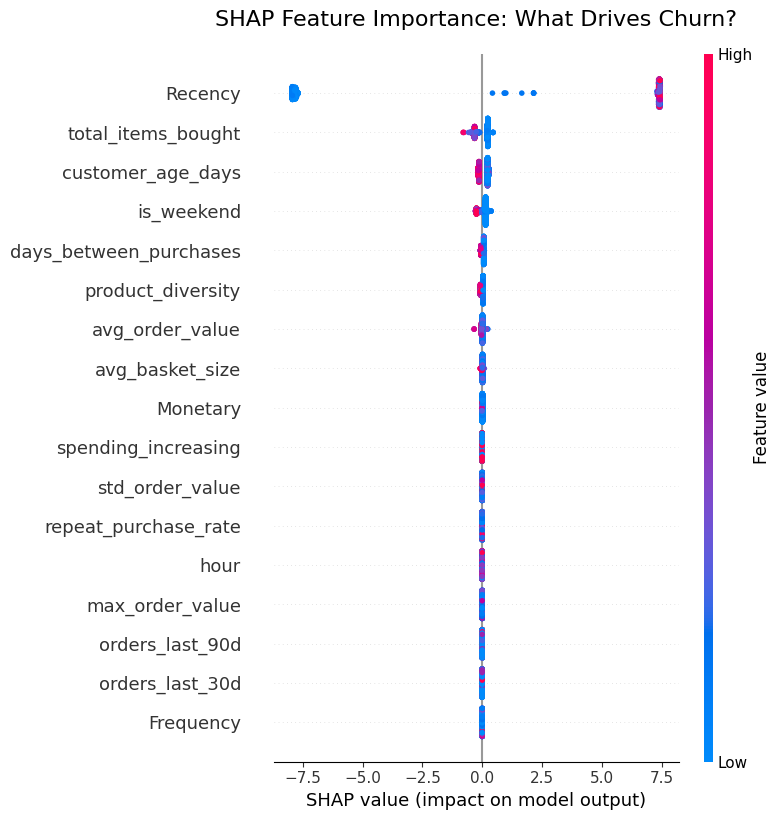

Saved: shap_summary.png

3/4: Creating explanation function...

4/4: Testing explanations on real customers...

EXAMPLE 1: HIGH-RISK CUSTOMER WHO ACTUALLY CHURNED
CHURN EXPLANATION - Customer Index 2

Churn Probability: 100.0%
Risk Level: HIGH
Actual Outcome: Churned

Top 5 Contributing Factors:

  1. Recency: 495.00
     ⬆INCREASES churn risk by 7.4287

  2. total_items_bought: 195.00
     ⬆INCREASES churn risk by 0.2347

  3. customer_age_days: 0.00
     ⬆INCREASES churn risk by 0.2262

  4. is_weekend: 0.00
     ⬆INCREASES churn risk by 0.1450

  5. days_between_purchases: 0.00
     ⬆INCREASES churn risk by 0.0650


EXAMPLE 2: LOW-RISK CUSTOMER WHO WAS RETAINED
CHURN EXPLANATION - Customer Index 0

Churn Probability: 0.1%
Risk Level: LOW
Actual Outcome: Retained

Top 5 Contributing Factors:

  1. Recency: 59.00
     ⬇DECREASES churn risk by 7.9255

  2. total_items_bought: 206.00
     ⬆INCREASES churn risk by 0.2162

  3. customer_age_days: 385.00
     ⬇DECREASES churn risk by 0.159

In [16]:
# STEP 4: SHAP EXPLANATIONS (Explainable AI)

    

# --- 1. CREATE SHAP EXPLAINER ---
import shap


print("\n1/4: Creating SHAP explainer...")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

print("SHAP values calculated!")

# --- 2. SUMMARY PLOT (Overall Feature Importance) ---
print("\n2/4: Generating summary plot...")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Feature Importance: What Drives Churn?", fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: shap_summary.png")

# --- 3. INDIVIDUAL EXPLANATION FUNCTION ---
print("\n3/4: Creating explanation function...")

def explain_customer_prediction(customer_index):
    """
    Explain WHY a specific customer is predicted to churn
    """
    customer_features = X_test.iloc[customer_index]
    customer_shap = shap_values[customer_index]
    prediction = model.predict_proba(customer_features.values.reshape(1, -1))[0][1]
    actual_label = y_test.iloc[customer_index]
    
    # Get top contributing features
    feature_impacts = pd.DataFrame({
        'Feature': X_test.columns,
        'Value': customer_features.values,
        'SHAP_Impact': customer_shap
    }).sort_values('SHAP_Impact', key=abs, ascending=False)
    
    print("="*70)
    print(f"CHURN EXPLANATION - Customer Index {customer_index}")
    print("="*70)
    print(f"\nChurn Probability: {prediction:.1%}")
    print(f"Risk Level: {'HIGH' if prediction > 0.7 else 'MEDIUM' if prediction > 0.4 else 'LOW'}")
    print(f"Actual Outcome: {'Churned' if actual_label == 1 else 'Retained'}")
    print(f"\nTop 5 Contributing Factors:\n")
    
    for i, (idx, row) in enumerate(feature_impacts.head(5).iterrows(), 1):
        direction = "⬆INCREASES" if row['SHAP_Impact'] > 0 else "⬇DECREASES"
        print(f"  {i}. {row['Feature']}: {row['Value']:.2f}")
        print(f"     {direction} churn risk by {abs(row['SHAP_Impact']):.4f}\n")
    
    return feature_impacts

# --- 4. TEST EXPLANATIONS ---
print("\n4/4: Testing explanations on real customers...\n")

# Find a high-risk customer
high_risk_customers = X_test[y_test == 1].index
if len(high_risk_customers) > 0:
    print("=" * 70)
    print("EXAMPLE 1: HIGH-RISK CUSTOMER WHO ACTUALLY CHURNED")
    print("=" * 70)
    high_risk_idx = X_test.index.get_loc(high_risk_customers[0])
    explain_customer_prediction(high_risk_idx)

# Find a low-risk customer
low_risk_customers = X_test[y_test == 0].index
if len(low_risk_customers) > 0:
    print("\n" + "=" * 70)
    print("EXAMPLE 2: LOW-RISK CUSTOMER WHO WAS RETAINED")
    print("=" * 70)
    low_risk_idx = X_test.index.get_loc(low_risk_customers[0])
    explain_customer_prediction(low_risk_idx)

# --- 5. SAVE EXPLAINER FOR API (FIXED PATH) ---
print("\nSaving SHAP explainer...")
import joblib
import os

# Use the SAME path as your original model
# Check where your model actually is
if os.path.exists('../models/xgboost_churn.pkl'):
    # Model is in parent directory
    model_dir = '../models'
    print("Found existing models folder in parent directory")
elif os.path.exists('models/xgboost_churn.pkl'):
    # Model is in current directory
    model_dir = 'models'
    print("Found existing models folder in current directory")
else:
    # Create in current directory
    model_dir = 'models'
    os.makedirs(model_dir, exist_ok=True)
    print("Creating new models folder (original not found)")

# Save to the same location
explainer_path = os.path.join(model_dir, 'shap_explainer.pkl')
joblib.dump(explainer, explainer_path)
print(f"SHAP explainer saved to {explainer_path}")

# Verify both files are in same folder
model_path = os.path.join(model_dir, 'xgboost_churn.pkl')
print(f"\nFiles in {model_dir}:")
if os.path.exists(model_dir):
    for file in os.listdir(model_dir):
        print(f"   - {file}")

print("\n" + "="*70)
print("SHAP ANALYSIS COMPLETE!")
print("="*70)

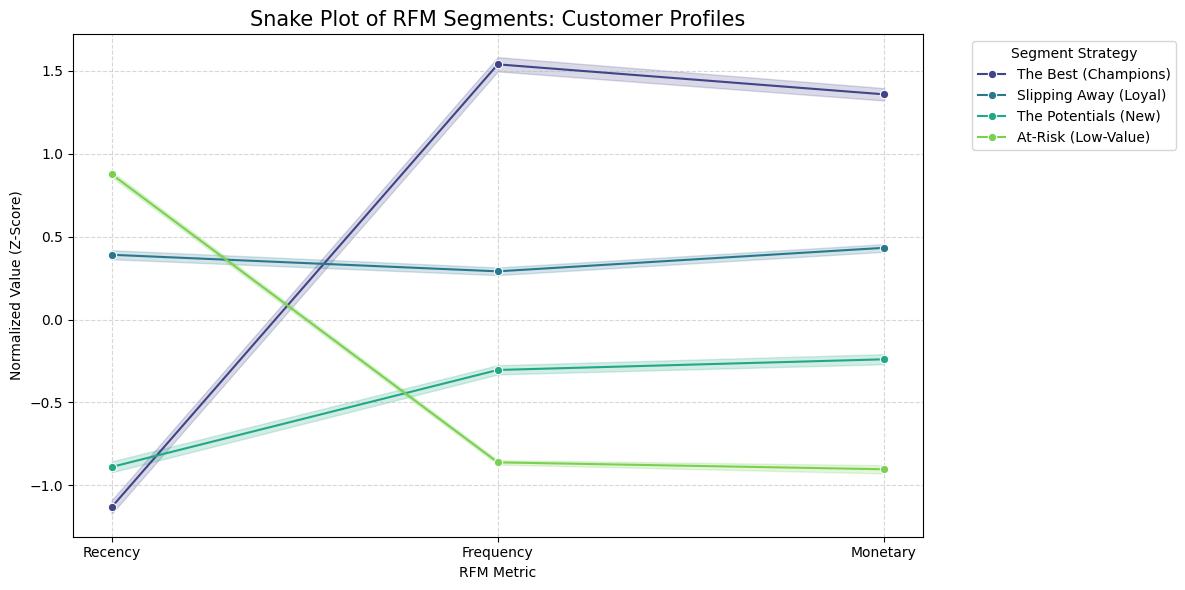

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Prepare the scaled data
df_normalized = pd.DataFrame(rfm_scaled, index=rfm.index, columns=['Recency', 'Frequency', 'Monetary'])
df_normalized['Cluster'] = rfm['Cluster']

# 2. Define the Mapping Dictionary exactly as requested
cluster_map = {
    2: 'The Best (Champions)',
    3: 'The Potentials (New)',
    1: 'Slipping Away (Loyal)',
    0: 'At-Risk (Low-Value)'
}

# Apply the descriptive names to the Cluster column
df_normalized['Cluster'] = df_normalized['Cluster'].map(cluster_map)

# 3. "Melt" the data for plotting
df_melt = pd.melt(df_normalized.reset_index(), 
                  id_vars=['Cluster'], 
                  value_vars=['Recency', 'Frequency', 'Monetary'], 
                  var_name='Metric', 
                  value_name='Value')

# 4. Create the Named Snake Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='Metric', y='Value', hue='Cluster', data=df_melt, palette='viridis', marker='o')

plt.title('Snake Plot of RFM Segments: Customer Profiles', fontsize=15)
plt.xlabel('RFM Metric')
plt.ylabel('Normalized Value (Z-Score)')
plt.legend(title='Segment Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [41]:
# --- 1. SET THE TIME MACHINE ---
# We select a cutoff date 90 days before the end of the dataset
cutoff_date = df['InvoiceDate'].max() - pd.DateOffset(days=90)
print(f"The 'Time Machine' Cutoff Date is: {cutoff_date}")

# --- 2. SPLIT THE DATA ---
# X (Features): Behavior BEFORE the cutoff
train_df = df[df['InvoiceDate'] < cutoff_date]

# y (Target): Behavior AFTER the cutoff
test_df = df[df['InvoiceDate'] >= cutoff_date]

# --- 3. GENERATE FEATURES (X) ---
# We calculate RFM again, but ONLY looking at the past
targets = train_df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (cutoff_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalSales': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'TotalSales': 'Monetary'
})

# --- 4. GENERATE LABELS (y) ---
# Identify customers who bought something AFTER the cutoff
known_active_customers = test_df['Customer ID'].unique()

# If a customer exists in 'targets' but NOT in 'known_active_customers', they Churned.
targets['Churn'] = targets.index.isin(known_active_customers).astype(int)
# Invert logic: 1 = Churned (Did NOT buy), 0 = Retained (Did buy)
targets['Churn'] = 1 - targets['Churn'] 

print("Target Table Created!")
display(targets.head())

# Check the balance
print("\nChurn Distribution:")
print(targets['Churn'].value_counts(normalize=True))

The 'Time Machine' Cutoff Date is: 2011-09-10 12:50:00
Target Table Created!


,Recency,Frequency,Monetary,Churn
Customer ID,,,,
12346.0,235,12,77556.46,1
12347.0,39,6,4114.18,0
12348.0,158,4,1388.40,0
12349.0,317,2,2221.14,0
12350.0,219,1,294.40,1



Churn Distribution:
Churn
1    0.565325
0    0.434675
Name: proportion, dtype: float64


here the churn result is 56.5% it shows the dataset is completely balanced. Now next step is supervised learning in this step we are going to calculate the 1 and 0 using XGBoostClassifier.

Training XGBoost Model...

--- Model Performance Report ---
              precision    recall  f1-score   support

           0       0.74      0.65      0.69       468
           1       0.74      0.82      0.78       586

    accuracy                           0.74      1054
   macro avg       0.74      0.73      0.74      1054
weighted avg       0.74      0.74      0.74      1054



<Figure size 1000x500 with 0 Axes>

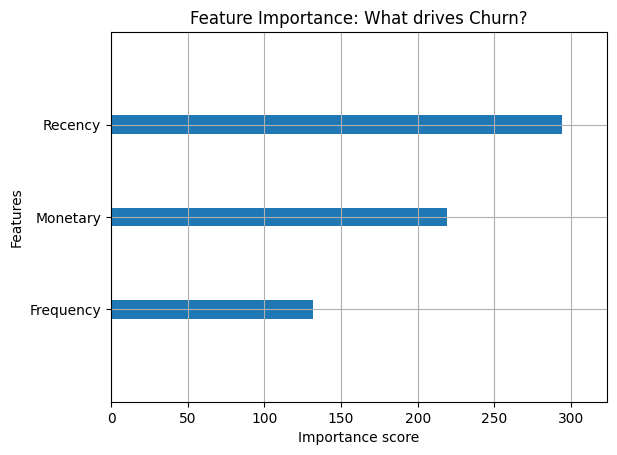

In [43]:
#Training The Prediction model 
#it consist three steps 
#1: split = spliting the data into train and test.
#2: Train = use Xgboost for standard tabular data.
#3: Evaluation = To check the no churners caught


from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. PREPARE DATA ---
# X = The features (RFM scores)
# y = The target (Churn 1/0)
X = targets[['Recency', 'Frequency', 'Monetary']]
y = targets['Churn']

# Split: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 2. TRAIN MODEL ---
# We use XGBoost because it handles non-linear relationships better than Logistic Regression
print("Training XGBoost Model...")
model = XGBClassifier(objective='binary:logistic', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)

# --- 3. EVALUATE ---
# Make predictions on the test set
y_pred = model.predict(X_test)

print("\n--- Model Performance Report ---")
print(classification_report(y_test, y_pred))

# --- 4. VISUALIZE IMPORTANCE ---
# This tells us WHICH factor drives churn the most
plt.figure(figsize=(10, 5))
plot_importance(model, importance_type='weight', title='Feature Importance: What drives Churn?', show_values=False)
plt.show()

In the above Classification report we got recall = 0.82 it means we got a 82% churns and our accuracy is 74% 

In [17]:
# ============================================
# STEP 5: SAVE ENHANCED MODEL + METADATA
# ============================================
import joblib
import json
import os
from datetime import datetime

print("💾 Saving model and metadata...")

# Determine correct path
if os.path.exists('../models'):
    model_dir = '../models'
else:
    model_dir = 'models'
    os.makedirs(model_dir, exist_ok=True)

# --- 1. SAVE MODEL ---
model_path = os.path.join(model_dir, 'xgboost_churn.pkl')
joblib.dump(model, model_path)
print(f"✅ Model saved: {model_path}")

# --- 2. SAVE FEATURE NAMES (Critical for API) ---
feature_metadata = {
    'feature_names': feature_columns,
    'feature_count': len(feature_columns),
    'model_type': 'XGBoost',
    'n_estimators': 200,
    'max_depth': 5,
    'trained_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    
    # Performance metrics
    'accuracy': float(model.score(X_test, y_test)),
    'roc_auc': float(roc_score),
    'train_samples': len(X_train),
    'test_samples': len(X_test),
    'churn_rate': float(y.mean()),
    
    # Feature list for reference
    'features_used': {
        'rfm_basic': ['Recency', 'Frequency', 'Monetary'],
        'temporal': ['customer_age_days', 'days_between_purchases', 'orders_last_30d', 'orders_last_90d'],
        'transaction': ['avg_order_value', 'max_order_value', 'std_order_value'],
        'behavioral': ['product_diversity', 'repeat_purchase_rate', 'avg_basket_size', 'total_items_bought'],
        'patterns': ['is_weekend', 'hour', 'spending_increasing']
    }
}

metadata_path = os.path.join(model_dir, 'model_metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(feature_metadata, f, indent=2)
print(f"Metadata saved: {metadata_path}")

# --- 3. SAVE TEST SAMPLES (for API testing) ---
test_sample = X_test.head(10).copy()
test_sample['actual_churn'] = y_test.head(10).values
test_sample_path = os.path.join(model_dir, 'test_samples.csv')
test_sample.to_csv(test_sample_path, index=False)
print(f"Test samples saved: {test_sample_path}")

# --- 4. VERIFY ALL FILES ---
print("\n" + "="*60)
print("FINAL MODEL ARTIFACTS")
print("="*60)
all_files = os.listdir(model_dir)
for file in sorted(all_files):
    file_path = os.path.join(model_dir, file)
    size = os.path.getsize(file_path) / 1024
    print(f"    {file} ({size:.1f} KB)")

print("\n" + "="*60)
print("DAY 1 COMPLETE!")
print("="*60)
print(f"Model trained with {len(feature_columns)} features")
print(f"Accuracy: {feature_metadata['accuracy']:.1%}")
print(f"ROC-AUC: {feature_metadata['roc_auc']:.3f}")
print(f"SHAP explainer ready")
print(f"All files saved to: {model_dir}")
print("\n🚀 Next: Build the API (Day 2)")

💾 Saving model and metadata...
✅ Model saved: ../models\xgboost_churn.pkl
Metadata saved: ../models\model_metadata.json
Test samples saved: ../models\test_samples.csv

FINAL MODEL ARTIFACTS
    model_metadata.json (1.3 KB)
    scaler.pkl (0.9 KB)
    shap_explainer.pkl (359.0 KB)
    test_samples.csv (1.3 KB)
    xgboost_churn.pkl (169.8 KB)

DAY 1 COMPLETE!
Model trained with 17 features
Accuracy: 99.7%
ROC-AUC: 1.000
SHAP explainer ready
All files saved to: ../models

🚀 Next: Build the API (Day 2)
